Let's train a very simple non-linear multivariate regression model using PyTorch.

In [90]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

Create a simple PyTorch Module. This Module models the function:

$y = M_2 (M_1 x + b_1) + b_2$

And you want to minimize:

$L = || y - y_{observed} ||^2 + \lambda_1 ||M_1||_F + + \lambda_2 ||M_2||_F$

where $x$ and $y$ are vectors and we're taking the Frobenius norm of our parameters. 

Note that $M_1$ and $M_2$ aren't necessarily square. In fact, if we set the shapes of $M_1$ and $M_2$ to be small we can try to "squeeze" into a smaller space and effectively build-in dimensionality reduction.

This whole model is slightly more complicated than vanilla linear regression, and is now something like quadratic (because of the two matrix multiplies) vector regression (because we're predicting a vector outcome, not a scalar one).

We can split the above model into three steps, which (1) initialize parameters, (2) compute a prediction, and (3) compute the loss.

- Declare that you'll be optimizing two linear functions. This saves space for $M_1$, $M_2$, $b_1$ and $b_2$, but not $x$ or $y$. Putting it in the `__init__` function of a `nn.Module` is special: PyTorch will remember that these parameters are optimize-able.
- `forward` tells us how to combine our parameters to make a prediction $y$
- `loss` tells us how to compare our prediction vector to our observed vector, plus how to minimize our regularizer.

In [13]:
class Bottleneck(nn.Module):
    def __init__(self, n_in_cols, n_out_cols, n_hidden=3):
        super(Bottleneck, self).__init__()
        self.lin1 = nn.Linear(n_in_cols, n_hidden)
        self.lin2 = nn.Linear(n_hidden, n_out_cols)
    
    def forward(self, x):
        # x is a minibatch of rows of our features
        hidden = self.lin1(x)
        # y is a minibatch of our predictions
        y = self.lin2(hidden)
        return y

    def loss(self, prediction, target, lam1=1e-3, lam2=1e-3):
        # This is just the mean squared error
        loss_likelihood = ((prediction - target)**2.0).sum()
        # This computes our Frobenius norm over both matrices
        # Note that we can access the Linear model's variables
        # directly if we'd like. No tricks here!
        loss_prior_m1 = (self.lin1.weight**2.0 * lam1).sum()
        loss_prior_m2 = (self.lin2.weight**2.0 * lam2).sum()
        loss = loss_likelihood + loss_prior_m1 + loss_prior_m2
        return loss

Let's make up some fake data to fit. Annoyingly, it has to be `float32` or `int64`.

In [91]:
X = np.random.normal(size=(2000, 9)).astype(np.float32)
Y = np.random.normal(size=(2000, 4)) + np.dot(X, np.random.normal(size=(9, 4)))
Y = Y.astype(np.float32)

In [92]:
X.shape, Y.shape

((2000, 9), (2000, 4))

Initialize the model. Note that we'll also initialize the "optimizer". Check out [this link](http://ruder.io/optimizing-gradient-descent/) to learn more about different optimizers. For now, `Adam` is a good choice.

In [94]:
model = Bottleneck(9, 4, 3)
o = optim.Adam(model.parameters())

In [95]:
model.lin1.weight.data.shape

torch.Size([3, 9])

In [96]:
model.lin2.weight.data.shape

torch.Size([4, 3])

In [97]:
model.lin1.bias.data.shape

torch.Size([3])

In [98]:
def chunks(array, size):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(array), size):
        yield array[i:i + size]

In [117]:

losses = []
for epoch in range(100):
    for feature, target in zip(chunks(X, batch_size), chunks(Y, batch_size)):
        # This zeros the gradients on every parameter. 
        # This is easy to miss and hard to troubleshoot.
        o.zero_grad()
        # Convert 
        feature = Variable(torch.from_numpy(feature))
        target = Variable(torch.from_numpy(target))
        # Compute a prediction for these features
        prediction = model.forward(feature)
        # Compute a loss given what the true target outcome was
        loss = model.loss(prediction, target)
        # break
        # Backpropagate: compute the direction / gradient every model parameter
        # defined in your __init__ should move in in order to minimize this loss
        # However, we're not actually changing these parameters, we're just storing
        # how they should change.

        loss.backward()
        # Now take a step & update the model parameters. The optimizer uses the gradient at 
        # defined on every parameter in our model and nudges it in that direction.
        o.step()
        print(epoch, loss.data)
        # Record the loss per example
        losses.append(loss.data.numpy() / len(feature))

0 tensor(3912.3611)
0 tensor(3239.2529)
0 tensor(3758.6479)
0 tensor(4353.4268)
0 tensor(4306.5386)
0 tensor(4121.1318)
0 tensor(3671.4946)
0 tensor(3610.9329)
0 tensor(3905.7747)
0 tensor(3391.9680)
0 tensor(3939.4470)
0 tensor(3969.4001)
0 tensor(3442.9907)
0 tensor(3715.4514)
0 tensor(3668.9883)
0 tensor(3481.9146)
0 tensor(3740.1189)
0 tensor(4086.3887)
0 tensor(3953.3496)
0 tensor(4307.7393)
1 tensor(3811.3464)
1 tensor(3152.7053)
1 tensor(3659.8035)
1 tensor(4220.3418)
1 tensor(4201.4194)
1 tensor(4002.2249)
1 tensor(3556.8242)
1 tensor(3514.1858)
1 tensor(3788.7561)
1 tensor(3285.8286)
1 tensor(3829.0540)
1 tensor(3853.2583)
1 tensor(3337.7039)
1 tensor(3602.3401)
1 tensor(3566.2385)
1 tensor(3384.7319)
1 tensor(3633.1165)
1 tensor(3956.6572)
1 tensor(3833.2573)
1 tensor(4178.8320)
2 tensor(3711.2632)
2 tensor(3063.3801)
2 tensor(3556.2358)
2 tensor(4081.6196)
2 tensor(4090.0613)
2 tensor(3877.6262)
2 tensor(3437.9001)
2 tensor(3413.5544)
2 tensor(3667.4480)
2 tensor(3177.9526)


26 tensor(1292.4033)
26 tensor(1338.7123)
26 tensor(1284.0883)
26 tensor(1413.0383)
27 tensor(1530.4760)
27 tensor(1199.0038)
27 tensor(1301.2258)
27 tensor(1309.9327)
27 tensor(1488.9257)
27 tensor(1237.6692)
27 tensor(1134.1301)
27 tensor(1215.2831)
27 tensor(1248.4071)
27 tensor(1200.6802)
27 tensor(1345.4410)
27 tensor(1242.0242)
27 tensor(1061.3578)
27 tensor(1205.2947)
27 tensor(1323.2413)
27 tensor(1275.2572)
27 tensor(1245.7477)
27 tensor(1288.6858)
27 tensor(1239.2335)
27 tensor(1361.8420)
28 tensor(1483.2881)
28 tensor(1158.5764)
28 tensor(1263.1777)
28 tensor(1261.9305)
28 tensor(1445.0970)
28 tensor(1194.9192)
28 tensor(1098.2296)
28 tensor(1180.9039)
28 tensor(1211.9487)
28 tensor(1168.5443)
28 tensor(1307.2347)
28 tensor(1197.7765)
28 tensor(1031.7676)
28 tensor(1162.1207)
28 tensor(1285.9626)
28 tensor(1235.2885)
28 tensor(1201.8784)
28 tensor(1241.6476)
28 tensor(1197.4777)
28 tensor(1313.9642)
29 tensor(1438.3420)
29 tensor(1120.6312)
29 tensor(1227.8993)
29 tensor(121

53 tensor(680.7222)
53 tensor(653.4822)
53 tensor(723.7817)
53 tensor(747.4148)
54 tensor(854.5171)
54 tensor(688.5907)
54 tensor(783.2564)
54 tensor(715.7577)
54 tensor(883.8415)
54 tensor(708.9225)
54 tensor(662.2761)
54 tensor(731.7794)
54 tensor(794.4352)
54 tensor(712.8215)
54 tensor(833.4124)
54 tensor(728.9763)
54 tensor(704.7569)
54 tensor(697.9402)
54 tensor(786.6505)
54 tensor(757.5290)
54 tensor(670.7944)
54 tensor(641.6089)
54 tensor(714.5453)
54 tensor(737.3104)
55 tensor(842.6299)
55 tensor(680.3459)
55 tensor(772.2144)
55 tensor(706.8083)
55 tensor(870.6471)
55 tensor(701.0382)
55 tensor(655.3158)
55 tensor(721.1840)
55 tensor(785.9220)
55 tensor(703.1826)
55 tensor(823.8802)
55 tensor(722.1561)
55 tensor(698.9247)
55 tensor(691.9819)
55 tensor(775.9437)
55 tensor(750.1926)
55 tensor(661.2721)
55 tensor(630.2955)
55 tensor(705.6104)
55 tensor(727.7342)
56 tensor(831.1923)
56 tensor(672.3779)
56 tensor(761.4629)
56 tensor(698.2958)
56 tensor(857.7374)
56 tensor(693.4601)


83 tensor(550.4169)
83 tensor(639.4023)
83 tensor(584.2230)
83 tensor(672.2209)
83 tensor(636.9806)
83 tensor(616.5156)
83 tensor(621.8341)
83 tensor(633.5986)
83 tensor(670.0648)
83 tensor(537.5642)
83 tensor(502.7473)
83 tensor(570.5934)
83 tensor(619.8745)
84 tensor(670.4870)
84 tensor(557.9370)
84 tensor(603.9662)
84 tensor(598.8213)
84 tensor(647.5925)
84 tensor(580.5446)
84 tensor(577.3069)
84 tensor(548.2340)
84 tensor(637.3745)
84 tensor(583.5449)
84 tensor(670.1146)
84 tensor(636.5258)
84 tensor(615.7781)
84 tensor(621.4768)
84 tensor(632.3129)
84 tensor(669.9159)
84 tensor(536.6320)
84 tensor(502.3509)
84 tensor(569.0466)
84 tensor(619.4066)
85 tensor(668.8028)
85 tensor(556.8642)
85 tensor(602.4636)
85 tensor(598.3492)
85 tensor(644.8979)
85 tensor(579.0839)
85 tensor(577.1190)
85 tensor(546.2164)
85 tensor(635.4964)
85 tensor(582.9672)
85 tensor(668.1487)
85 tensor(636.1482)
85 tensor(615.1203)
85 tensor(621.1809)
85 tensor(631.1480)
85 tensor(669.8344)
85 tensor(535.8088)


I can introspect my model and get the parameters out:

In [103]:
model.lin1.weight.data.numpy()

array([[ 0.00793472, -0.18439063, -0.13740039,  0.11674964,  0.23016426,
         0.24604872, -0.09360509, -0.228513  ,  0.30817774],
       [ 0.21290532, -0.249387  , -0.33065504,  0.07904044, -0.25788367,
         0.16649047, -0.05183586, -0.12866132,  0.23517433],
       [-0.23871288,  0.2849147 , -0.18879056, -0.07684752, -0.15514359,
        -0.04104719,  0.00463989, -0.12159058, -0.28858423]],
      dtype=float32)

In [104]:
model.lin1.bias.data.numpy()

array([-0.06353128, -0.10602567,  0.21432808], dtype=float32)

I can also see that the loss is simply a scalar:

In [105]:
loss

tensor(4414.6069, grad_fn=<ThAddBackward>)

You can see that the gradient is zero before we call `loss.backward()`

In [111]:
model.lin1.bias.grad

tensor([0., 0., 0.])

...And non-zero afterwards.

In [113]:
model.lin1.bias.grad

tensor([-106.8074,   76.9383,   88.2186])

In [116]:
model.lin1.bias.data

tensor([ 0.0300, -0.2070,  0.1185])

And after we run `o.step()` we'll notice that the bias parameter has been updated:

In [88]:
model.lin1.bias.data.numpy()

array([ 0.25160268, -0.03068716,  0.23243836], dtype=float32)

Let's check on convergence:

In [118]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

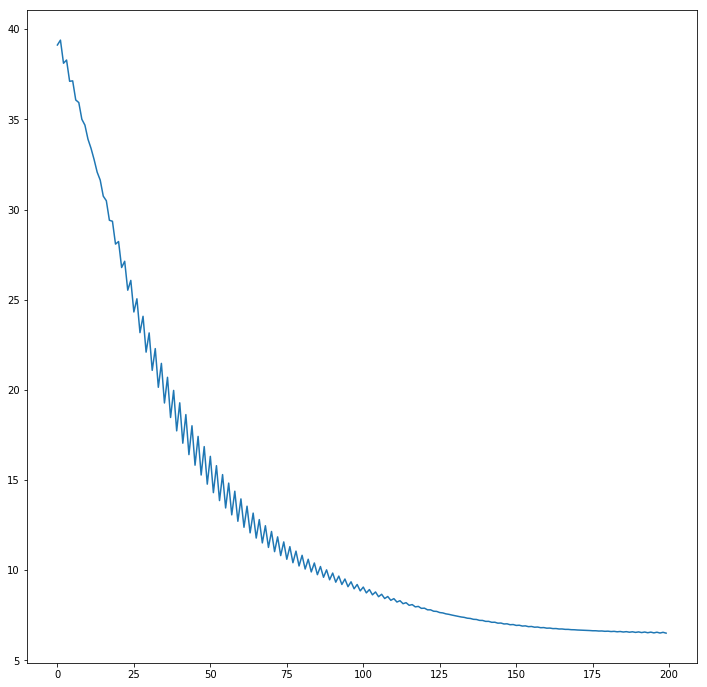

In [119]:
n = len(losses)
smooth = np.convolve(losses, np.ones((n,))/n, mode='valid')
plt.figure(figsize=(12, 12))
plt.plot(losses[::10])
plt.plot(smooth, c='r')

Looks converged to me!